# Demand Forecasting Predictions 

***Let's get started.***

![Walmart](https://nypost.com/wp-content/uploads/sites/2/2019/08/walmart-tesla.jpg?quality=80&strip=all&w=618&h=410&crop=1)

## Info

* This notebook is for the capstone project for Udacitys Nanodegree - **Machine Learning Engineer**. More information about the project will be provided below. 

* To test the prediciton score, we will submit the predictions to the Kaggle competition by Walmart which the data originated from, see link [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview). 

# Structure 

1. Import libraries and set up Dataframes
2. Explore the Data
3. Create Train & Test Data
4. Set up Benchmark Model Score
5. Create & Test models 
6. Summary of Results & Pick winning model for submission
7. Submission Score & Comparison to Benchmark

# 1. Import Libraries & Set up Data

**The first stage.**

![Kaggle](https://dox4euoyzny9u.cloudfront.net/images/blog/uploads/dataprocessinggdpr.jpg)

### What will we will do in this section?

* In this section we will import the nessessary libraries and the data from kaggle.com. 
* Link to dataset **[here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview).**

* We will then proceed and create dataframes (df's) that match each other, so we can try to answer the final question of; ***Predict the department-wide sales for each store***.


### Libraries to import

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from lofo import LOFOImportance # https://github.com/aerdem4/lofo-importance
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import math
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

### Data to import

In [3]:
# Import data
df_f = pd.read_csv("data/features.csv")
df_st = pd.read_csv("data/stores.csv")
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


# check the data
df_test.head(3)

Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False

In [4]:
# Make date column into datetime
df_f["Date"] = pd.to_datetime(df_f["Date"])
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# Test if it works
print(df_train[0:1].Date, df_train[-1:].Date)
print(df_test[0:1].Date, df_test[-1:].Date)
print(df_f[0:1].Date, df_f[-1:].Date)

0   2010-02-05
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2012-11-02
Name: Date, dtype: datetime64[ns] 115063   2013-07-26
Name: Date, dtype: datetime64[ns]
0   2010-05-02
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


In [5]:
# Assess the total amount of columns and rows in a more consise way
print(df_f.shape)
print(df_train.shape)
print(df_test.shape)
print(df_st.shape)

(8190, 12)
(421570, 5)
(115064, 4)
(45, 3)


##### What do we know about our data so far?
* So we can see we are working with over 421 570 rows of data in the train dataframe, over 5 columns. This looks like it's this large due to the fact of the 45 different stores. 

* Moreover, for our test data we have 115 063 rows of data over 5 columns. 


* Then we have 8190 rows of data over 12 different columns in the Features dataframe. 

* Finally we have 45 rows of data over 3 columns in the stores dataframe. 

***Next** we will proceed to address the NaN values we could identify in the .head() formula above.*

### Merge data into 1 DataFrame

We do this to get some assistance in assessing the features and the time when we proceed with the modeling. 

In [6]:
# Merging training data
df_all_train = df_train.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
#df_all_train.head(3)

# Merging test data
df_all_test = df_test.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_test.tail(3)


Store  Dept       Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
115061     45    98 2013-07-12      False          NaN         NaN        NaN   
115062     45    98 2013-07-19      False        82.84       3.737    2961.49   
115063     45    98 2013-07-26      False        76.06       3.804     212.02   

        MarkDown2  MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  
115061        NaN        NaN        NaN        NaN  NaN           NaN  
115062    1047.07     204.19     363.00    1059.46  NaN           NaN  
115063     851.73       2.06      10.88    1864.57  NaN           NaN

In [7]:
# More merging of training data
df_all_train = df_all_train.merge(df_st, how="left", on=["Store"])
df_all_train.head(3)

# More merging of test data
df_all_test = df_all_test.merge(df_st, how="left", on=["Store"])
#df_all_test.head(3)


In [8]:
# Check how our final df_all_train looks
print("Rows & Columns: ", df_all_train.shape, "\nAll columns if the df: ", df_all_train.columns.tolist())

# # Check how our final df_all_test looks
print("Rows & Columns: ", df_all_test.shape, "\nAll columns if the df: ", df_all_test.columns.tolist())


Rows & Columns:  (421570, 16) 
All columns if the df:  ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']
Rows & Columns:  (115064, 15) 
All columns if the df:  ['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


### What is in our new *df_all* dataframe?

* **What is included?** All columns from the three original files are now in the same dataframe, being; *'Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'*
* **Why do it this way?** We got everything in the same df now to proceed to fix NaN values etc to keep everything at the same place. If we need specific columns, we don't need to go through specific files, we have everything at the same place, which makes it easier to keep in check. 

In [9]:
df_all_train = df_all_train.applymap(lambda x: 1 if x == True else x)
df_all_train = df_all_train.applymap(lambda x: 0 if x == False else x)

df_all_test = df_all_test.applymap(lambda x: 1 if x == True else x)
df_all_test = df_all_test.applymap(lambda x: 0 if x == False else x)

In [10]:
# Checking the DFs
df_all_train.head(3)
#df_all_test.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50          0          NaN         NaN   
1      1     1 2010-02-12      46039.49          1          NaN         NaN   
2      1     1 2010-02-19      41595.55          0        39.93       2.514   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN         NaN   
1        NaN        NaN        NaN        NaN        NaN         NaN   
2        NaN        NaN        NaN        NaN        NaN  211.289143   

   Unemployment Type    Size  
0           NaN    A  151315  
1           NaN    A  151315  
2         8.106    A  151315

### Deal with NaN values 

In [11]:
# Check where we find NaN values

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

Store   Dept            Date Weekly_Sales IsHoliday  \
column Type       int64  int64  datetime64[ns]      float64     int64   
null values (nb)      0      0               0            0         0   
null values (%)       0      0               0            0         0   

                 Temperature Fuel_Price MarkDown1 MarkDown2 MarkDown3  \
column Type          float64    float64   float64   float64   float64   
null values (nb)      138586     138586    312211    333176    325015   
null values (%)      32.8738    32.8738   74.0591   79.0322   77.0963   

                 MarkDown4 MarkDown5      CPI Unemployment    Type   Size  
column Type        float64   float64  float64      float64  object  int64  
null values (nb)    324027    311805   138586       138586       0      0  
null values (%)     76.862   73.9628  32.8738      32.8738       0      0

In [12]:
#replace Temperature, fule price, CPI and unemployment with averages. 
# This seems more reasonable than replacing them with "0"s.                                                
df_all_train[["Temperature"]] = df_all_train[["Temperature"]].fillna(df_all_train[["Temperature"]].mean())
df_all_train[["Fuel_Price"]] = df_all_train[["Fuel_Price"]].fillna(df_all_train[["Fuel_Price"]].mean())
df_all_train[["CPI"]] = df_all_train[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_train[["Unemployment"]] = df_all_train[["Unemployment"]].fillna(df_all_train[["Unemployment"]].mean())

df_all_test[["Temperature"]] = df_all_test[["Temperature"]].fillna(df_all_test[["Temperature"]].mean())
df_all_test[["Fuel_Price"]] = df_all_test[["Fuel_Price"]].fillna(df_all_test[["Fuel_Price"]].mean())
df_all_test[["CPI"]] = df_all_test[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_test[["Unemployment"]] = df_all_test[["Unemployment"]].fillna(df_all_test[["Unemployment"]].mean())

In [13]:
# Check the results
df_all_train.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50          0    59.935594    3.380391   
1      1     1 2010-02-12      46039.49          1    59.935594    3.380391   
2      1     1 2010-02-19      41595.55          0    39.930000    2.514000   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  171.373307   
1        NaN        NaN        NaN        NaN        NaN  171.373307   
2        NaN        NaN        NaN        NaN        NaN  211.289143   

   Unemployment Type    Size  
0      7.940535    A  151315  
1      7.940535    A  151315  
2      8.106000    A  151315

In [14]:
# Replace the NaN values in markdown with 0
df_all_train = df_all_train.fillna(0)
df_all_test = df_all_test.fillna(0)

In [15]:
# Check the results
df_all_train.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50          0    59.935594    3.380391   
1      1     1 2010-02-12      46039.49          1    59.935594    3.380391   
2      1     1 2010-02-19      41595.55          0    39.930000    2.514000   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  171.373307   
1        0.0        0.0        0.0        0.0        0.0  171.373307   
2        0.0        0.0        0.0        0.0        0.0  211.289143   

   Unemployment Type    Size  
0      7.940535    A  151315  
1      7.940535    A  151315  
2      8.106000    A  151315

In [16]:
# Check NaN values in df_all_train

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

Store   Dept            Date Weekly_Sales IsHoliday  \
column Type       int64  int64  datetime64[ns]      float64     int64   
null values (nb)      0      0               0            0         0   
null values (%)       0      0               0            0         0   

                 Temperature Fuel_Price MarkDown1 MarkDown2 MarkDown3  \
column Type          float64    float64   float64   float64   float64   
null values (nb)           0          0         0         0         0   
null values (%)            0          0         0         0         0   

                 MarkDown4 MarkDown5      CPI Unemployment    Type   Size  
column Type        float64   float64  float64      float64  object  int64  
null values (nb)         0         0        0            0       0      0  
null values (%)          0         0        0            0       0      0

In [17]:
# Check NaN values in df_all_test

tab_info = pd.DataFrame(df_all_test.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()/df_all_test.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

Store   Dept            Date IsHoliday Temperature  \
column Type       int64  int64  datetime64[ns]     int64     float64   
null values (nb)      0      0               0         0           0   
null values (%)       0      0               0         0           0   

                 Fuel_Price MarkDown1 MarkDown2 MarkDown3 MarkDown4 MarkDown5  \
column Type         float64   float64   float64   float64   float64   float64   
null values (nb)          0         0         0         0         0         0   
null values (%)           0         0         0         0         0         0   

                      CPI Unemployment    Type   Size  
column Type       float64      float64  object  int64  
null values (nb)        0            0       0      0  
null values (%)         0            0       0      0

### Create Dummy Variables for Type of Store

* We do this in order to analyse the data, as a non-numerical value will not be processed in our models.

In [18]:
df_all_train = pd.get_dummies(df_all_train, columns=["Type"])
df_all_test = pd.get_dummies(df_all_test, columns=["Type"])

In [19]:
# Checking the DFs after all of the processing
df_all_train.head(3)
#df_all_test.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50          0    59.935594    3.380391   
1      1     1 2010-02-12      46039.49          1    59.935594    3.380391   
2      1     1 2010-02-19      41595.55          0    39.930000    2.514000   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  171.373307   
1        0.0        0.0        0.0        0.0        0.0  171.373307   
2        0.0        0.0        0.0        0.0        0.0  211.289143   

   Unemployment    Size  Type_A  Type_B  Type_C  
0      7.940535  151315       1       0       0  
1      7.940535  151315       1       0       0  
2      8.106000  151315       1       0       0

### Done with data cleaning and processing

- We can now proceed to explore the data

______
# 2. Data Exploration

**Ways we will explore the data:**
- .describe() function - general overview
- General plots for the different features
- Get average weekly sales for each store/department
- plot of sales 
- correlation heatmap

![Data](https://codemyviews-blog-post-images.s3.amazonaws.com/uploads/machine-learning.png)

In [20]:
# Start with simple .describe() to get the general jist of the dataframe
df_all_train.describe()

Store           Dept   Weekly_Sales      IsHoliday  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123       0.070358   
std        12.785297      30.492054   22711.183519       0.255750   
min         1.000000       1.000000   -4988.940000       0.000000   
25%        11.000000      18.000000    2079.650000       0.000000   
50%        22.000000      37.000000    7612.030000       0.000000   
75%        33.000000      74.000000   20205.852500       0.000000   
max        45.000000      99.000000  693099.360000       1.000000   

         Temperature     Fuel_Price      MarkDown1      MarkDown2  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       59.935594       3.380391    1741.105906     836.721983   
std        14.922062       0.367601    5233.469121    5062.933330   
min         5.540000       2.472000       0.000000    -265.760000   
25%        54.200000       3.200000       0.000000       0.000000   
50%        59.935594       3.380391       0.000000       0.000000   
75%        68.270000       3.611000      82.230000       0.000000   
max       100.140000       4.449000   88646.760000  104519.540000   

           MarkDown3      MarkDown4      MarkDown5            CPI  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean      436.075567     714.599910    1077.072079     171.373307   
std      5501.323559    3498.770639    3291.952301      32.121367   
min        -1.000000       0.000000       0.000000     126.064000   
25%         0.000000       0.000000       0.000000     136.557015   
50%         0.000000       0.000000       0.000000     171.373307   
75%         0.000000       0.000000     597.940000     198.100106   
max    141630.610000   67474.850000  105223.110000     227.232807   

        Unemployment           Size         Type_A         Type_B  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean        7.940535  136727.915739       0.511132       0.387824   
std         1.523905   60980.583328       0.499877       0.487255   
min         3.879000   34875.000000       0.000000       0.000000   
25%         7.368000   93638.000000       0.000000       0.000000   
50%         7.940535  140167.000000       1.000000       0.000000   
75%         8.200000  202505.000000       1.000000       1.000000   
max        14.313000  219622.000000       1.000000       1.000000   

              Type_C  
count  421570.000000  
mean        0.101044  
std         0.301387  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

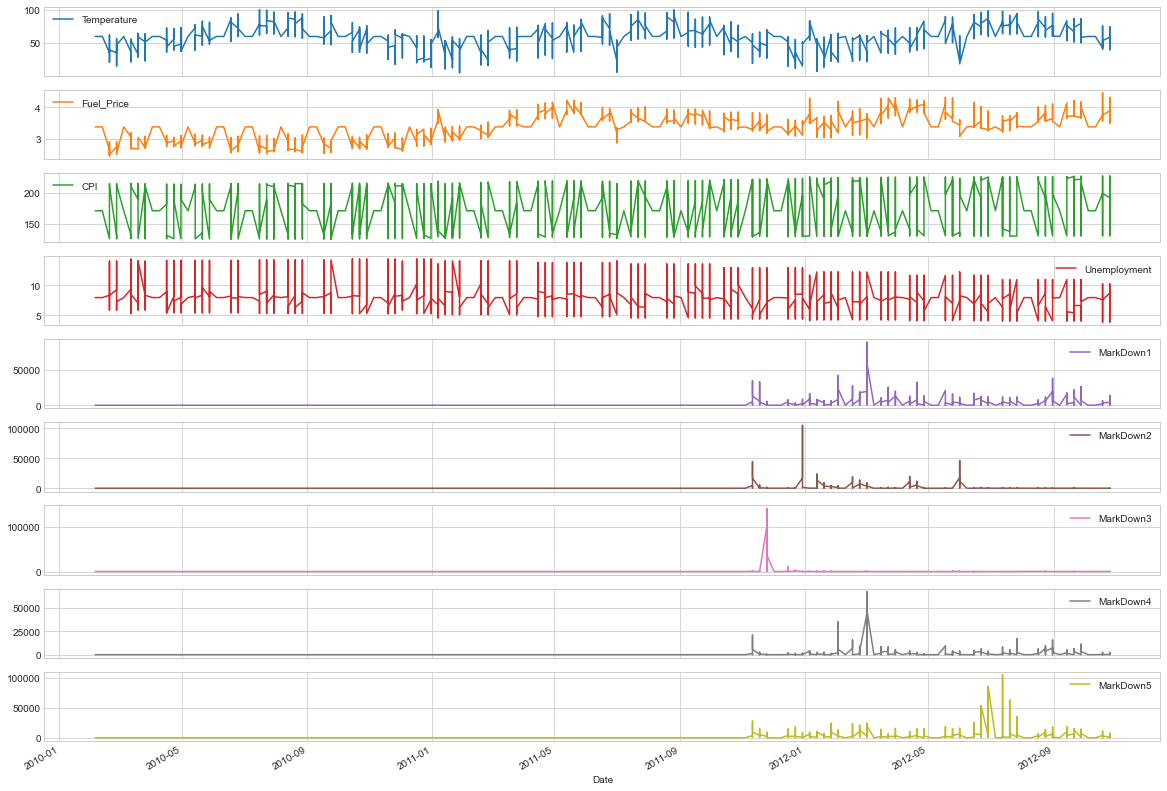

In [21]:
# Plots for the different features in the df: 
df_all_train[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

### *General comments about the graphs*

* **Discounts**: We have a few spikes, but not too many to make assumptions of the affects of it. It seems like the discounts are a more recent thing appearing in the end of 2011 with the exception of the potential test of 2011-02 where we find a small bump on all discount levels.
* **Temperature**: it seems like it is decently seasonal, which sounds reasonable when we talk about temperature on a YoY basis. 
* **Fuel Price**: Seems to have a slight positive trend. 
* **Unemployment**: Seems to have a slight negative trend over this timeframe. 

____
### Weekly sales plot

<function matplotlib.pyplot.show(*args, **kw)>

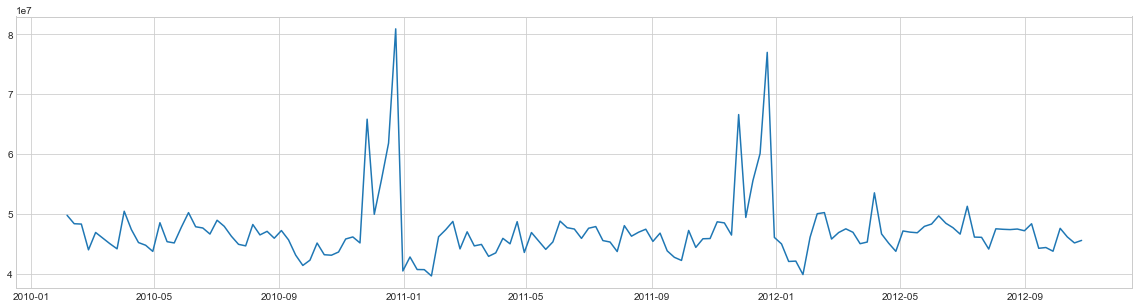

In [22]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = df_all_train.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

#print(df_average_sales[:10])

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.show

### *General comments about the graph* 

* **Seasonality - *High-Point***: It seems there are some seasonality to our data, where the end of December seems like a popular time to buy our company's specific products. Hy theory is that this has to do with the holidays and people buy gifts for each other, which seems reasonable. 
* **Seasonality - *Low-Point***: Around the end of january it seems to be a pretty steep dip in the different stores sales both during 2011 and 2012. 

#### Creating dummy variables for each month 

In [23]:
df_all_train["month"] = df_all_train['Date'].dt.month
df_all_train = df_all_train.drop(["Date"], axis=1)
df_all_train = pd.get_dummies(df_all_train, columns=["month"])#, prefix='month')
#df_all_train = df_all_train.drop('Date', 1)

df_all_test["month"] = df_all_test['Date'].dt.month
df_all_test = df_all_test.drop(["Date"], axis=1)
df_all_test = pd.get_dummies(df_all_test, columns=["month"])#, prefix='month')
#df_all_test = df_all_test.drop('Date', 1)

### Correlation heat map

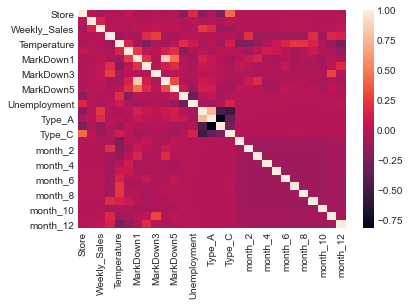

In [24]:
# Correlation between all features
sns.heatmap(df_all_train.corr())

In [25]:
# Correlation between Weekly Sales and all other features
df_all_train_corr = df_all_train[df_all_train.columns[:]].corr()['Weekly_Sales'][:]
df_all_train_corr = df_all_train_corr.drop("Weekly_Sales")
df_all_train_corr

Store          -0.085195
Dept            0.148032
IsHoliday       0.012774
Temperature    -0.007239
Fuel_Price     -0.003203
MarkDown1       0.033815
MarkDown2       0.022219
MarkDown3       0.037148
MarkDown4       0.024895
MarkDown5       0.036331
CPI            -0.016712
Unemployment   -0.022921
Size            0.243828
Type_A          0.185417
Type_B         -0.131219
Type_C         -0.095388
month_1        -0.019867
month_2         0.000368
month_3        -0.007876
month_4        -0.004804
month_5        -0.002728
month_6         0.004789
month_7        -0.001731
month_8         0.001129
month_9        -0.012330
month_10       -0.010273
month_11        0.016193
month_12        0.040980
Name: Weekly_Sales, dtype: float64

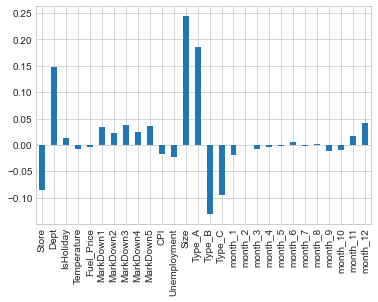

In [26]:
# Plot the correlation 
df_all_train_corr.plot.bar()

### General comments about the graph
The correlation table and graph indicate a few things: 
* **MarkDowns**: Not that significant in terms of weekly sales
* **Size**: Highest correlation of all, telling us that having a larger store = more sales. Only thing to notice is that this could imply that having larger stores will automatically increase revenues, but it could be linked to the location and being situated where a lot of people are, and therefore it results in higher revenue. In short, we can apply the old saying "Correlation is not causation". But it will b
* **Type**: Type_A seems to have a positive correlation with the 
* **Department**: Positive correlation with sales as well. 

_______
# 3. Create Train & Test Data.

**Making the data ready to use in our models.**

![data](https://www.kaggle.com/static/images/host-home/host-home-research.png)

In [27]:
# DF x & y
train_all = df_all_train # make it shorter syntax

train_X = df_all_train.drop(["Weekly_Sales", "month_8", "month_9", "month_10"], axis=1)
train_y = train_all["Weekly_Sales"]
test_X = df_all_test # making the syntax shorter --> Sub = submission

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

#### Check so that the dfs looks alright.

In [28]:
#X_train.shape
#X_test.shape

X_train.head(3)
#y_train.head(3)

#X_test.head(3)
#y_test.head(3)

#test_X.head(3)

Store  Dept  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1     1          0    59.935594    3.380391        0.0        0.0   
1      1     1          1    59.935594    3.380391        0.0        0.0   
2      1     1          0    39.930000    2.514000        0.0        0.0   

   MarkDown3  MarkDown4  MarkDown5  ...  Type_C  month_1  month_2  month_3  \
0        0.0        0.0        0.0  ...       0        0        1        0   
1        0.0        0.0        0.0  ...       0        0        1        0   
2        0.0        0.0        0.0  ...       0        0        1        0   

   month_4  month_5  month_6  month_7  month_11  month_12  
0        0        0        0        0         0         0  
1        0        0        0        0         0         0  
2        0        0        0        0         0         0  

[3 rows x 25 columns]

_______
# 4. Benchmark

**How will we benchmark our results?**

![ML](https://www.kaggle.com/static/images/about/inclass/howitworks@2x.png)

* The initial benchmarking will be made by looking at three different metrics used for estimating errors, as well as one statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. These are: 

**Error Metrics:**
1. Mean Absolute Error (MAE)
2. Mean Sqared Error (MSE)
3. Root Mean Squared Error (RMSE)

**Model Valuation Metric *(robustness of the model):***
1. R-squared (R^2)


* On the kaggle competition we have 688 submissions. Our benchmark will be the 50%th percentile score. Currently it's held by the user "Hari Khanal", with the score of **3985.79966**. 
* The lower the score, the better the prediction.
* The goal is to provide a better result than Frankin's model, which in turn would make our model *better than average*. 

You'll find the link to the scoreboard [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/leaderboard). 

______
# 5. Modeling

***Finding the best model.***

![ML](https://www.kth.se/polopoly_fs/1.862339.1554801965!/image/startpuff-avdelning_matematisk%20statistik.jpg)


#### We will limit this test to 8 different models:

1. Linear Regression (Linear model)
2. KNeighborsRegressor (KNN) (neighbors model)
3. Decision Tree Regressor (Tree model)
4. Random Forest Regressor (Enemble model)
5. Extra Trees Regressor (Ensemble model)
6. XGBoost (gradient boosted decision trees)
7. Ridge (Linear model)
8. Lasso (Linear model)


*We will start by creating train, test and final datasets.*



_____
## Linear Regression

In [29]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [34]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  11791.51373494347
MSE:  338619797.9313162
RMSE:  18401.624872040953
R^2: 0.06504501127637086


_______
## KNN Regressor 

In [35]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [36]:
from sklearn import metrics

# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  7834.987650520672
MSE:  221841899.43485868
RMSE:  14894.357973234653
R^2: 0.3874776612245894


_______
## Decision Tree Regressor

In [37]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [38]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  4745.773349451533
MSE:  96431498.96198909
RMSE:  9819.954122193703
R^2: 0.7337453049839202


_____
## Random Forest Regressor

In [39]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [40]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  4267.170097112522
MSE:  80946568.05601971
RMSE:  8997.031068970458
R^2: 0.7765003756827497


_____

## Extra Trees Regressor

In [41]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion="mse", max_depth=None,
                                      max_features="auto", max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=2, min_samples_split=5,
                                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
                                      oob_score=False, random_state=None, warm_start=False)
etr_random_best.fit(X_train, y_train)

ExtraTreesRegressor(min_samples_leaf=2, min_samples_split=5, n_jobs=30)

In [42]:
y_pred = etr_random_best.predict(X_test)

In [43]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  3535.2593445429543
MSE:  54359852.62139243
RMSE:  7372.913441875771
R^2: 0.8499083169231559


______
## XGBoost

In [44]:
xg = XGBRegressor()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

In [45]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  5606.465877917924
MSE:  87613186.09610133
RMSE:  9360.191563002401
R^2: 0.7580933367778552


________
## Ridge

In [46]:
rid = Ridge()
rid.fit(X_train, y_train)
y_pred = rid.predict(X_test)

In [47]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  11791.422227827257
MSE:  338620263.35266346
RMSE:  18401.637518239062
R^2: 0.06504372621267074


________
## Lasso

In [48]:
las = Lasso()
las.fit(X_train, y_train)
y_pred = las.predict(X_test)

In [49]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  11784.147085101193
MSE:  338648906.30724734
RMSE:  18402.41577367622
R^2: 0.06496464083891662


________

# 6. Summarising Results & Optimal Model

**The #1 model.**

![Model](https://png.pngtree.com/template/20190214/ourlarge/pngtree-aquare-letter-d-and-number-one-logo-vector-image_55711.jpg)

### ACCUARY 
#### Best performer 

* Extra Trees Regressor
    * MAE:  3576.95
    * MSE:  54517368.39
    * RMSE:  7383.58

#### Worst performer

* Ridge Regressor
    * MAE:  11791.42
    * MSE:  338620263.35
    * RMSE:  18401.64
___
### MODEL ROBUSTNESS 
#### Best performer 

* Extra Trees Regressor
    * R^2 = 0.85

#### Worst performer

* Linear Regression
    * R^2 = 0.06
___

## AND THE OVERALL WINNER IS...

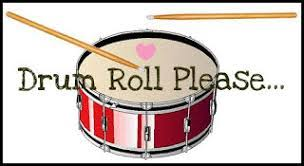

# --> Extra Trees Regressor! <---

______
### Final comments about the models

* **Linear models:** We find that the three linear models were not close to assist in the predictions with a R^2 score of less than 0.1.

_______

# 7. Submission Score & Comparison to Benchmark

***The final stop.***

![put](https://miro.medium.com/max/1200/1*joDRjoQDx4nJ4R8R5YkfoA.jpeg)

### Print the predictions for the final submission

In [50]:
y_pred = etr_random_best.predict(test_X) # Un-test data for the final submission

In [89]:
#pred = pd.DataFrame(y_pred.astype(str))
pred["Weekly_Sales"] = pd.DataFrame(y_pred.astype(str))

In [90]:
pred.head(3)

0        Weekly_Sales
0  26936.498792   26936.49879166668
1  26936.498792   26936.49879166668
2  18957.293050  18957.293050000022

In [91]:
Id = pd.DataFrame(df_test[["Store", "Dept","Date"]])
Id.head(3)

Store  Dept       Date
0      1     1 2012-11-02
1      1     1 2012-11-09
2      1     1 2012-11-16

In [92]:
Id["Id"] = Id["Store"].astype(str) + "_" + Id["Dept"].astype(str) + "_" + Id["Date"].astype(str)
Id.head(3)

Store  Dept       Date              Id
0      1     1 2012-11-02  1_1_2012-11-02
1      1     1 2012-11-09  1_1_2012-11-09
2      1     1 2012-11-16  1_1_2012-11-16

In [93]:
Id = pd.DataFrame(Id["Id"])
Id.head(3)

Id
0  1_1_2012-11-02
1  1_1_2012-11-09
2  1_1_2012-11-16

In [98]:
#submission = pd.DataFrame(Id["Id"]) + pd.DataFrame(pred["Weekly_Sales"])
#submission = pd.concat([Id["Id"], pred["Weekly_Sales"]])
#submission pd.DataFrame({'date':df.date,'Anomaly':tmp.Anomaly.combine_first(df.Anomaly)}
#submission = pd.DataFrame({})
submission = pd.concat([Id,pred["Weekly_Sales"]], axis = 1)

In [101]:
#submission.head(3)
submission.shape # Needs to be 115064 predicitons according to the competition

(115064, 2)

### Create CSV

In [100]:
submission.to_csv("Weekly_Sales_Prediction.csv", index=False)

_____
# Results Score from Kaggle

* We get a score of ***3883.47399*** which puts us in a better spot than our benchmark: Hari Khanal", with the score of ***3985.79966.*** 


![kaggle](kaggle_score.png)

## *WE DID IT!*

## Final thoughts

* This project was incredibly fun and spending over 60 hours on it was woithout a doubt definitely worth it. 

![celebrate](https://www.pblworks.org/sites/default/files/inline-images/celebration.jpg)